# African SME Job Creation Through Digital Transformation

## Mission: Eradicating Youth Unemployment by Predicting & Enabling Job Creation

**Dataset**: 1,000 African SMEs across Ghana, Kenya, Nigeria, Rwanda, South Africa  
**Target**: Predict employees (direct job creation metric)  
**Problem**: Youth unemployment at 20%+, SMEs create 80% of jobs  
**Solution**: Identify which digital strategies help SMEs hire more youth

**Countries**: Ghana, Kenya, Nigeria, Rwanda, South Africa  
**Sectors**: Education, Farming, Finance, Logistics, Manufacturing, Retail  
**Key Question**: What digital transformation strategies predict how many jobs an African SME will create?


In [7]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully!')


All libraries imported successfully!


In [8]:
# Step 2: Load the African SME Dataset
df = pd.read_csv('african_sme_digital_transformation.csv')

print('Dataset loaded successfully!')
print(f"\n{'='*60}")
print(f'DATASET OVERVIEW')
print(f"{'='*60}")
print(f'Total SMEs: {len(df)}')
print(f'Features: {len(df.columns)}')
print(f"Countries: {df['country'].nunique()}")
print(f"Sectors: {df['sector'].nunique()}")
print(f"\nEmployee Range: {df['employees'].min()} - {df['employees'].max()}")
print(f"Average Employees: {df['employees'].mean():.1f}")
print(f"Median Employees: {df['employees'].median():.1f}")

print(f"\n{'='*60}")
print('First 5 rows:')
print(f"{'='*60}")
df.head()


Dataset loaded successfully!

DATASET OVERVIEW
Total SMEs: 1000
Features: 12
Countries: 5
Sectors: 6

Employee Range: 5 - 499
Average Employees: 257.4
Median Employees: 261.0

First 5 rows:


,company_id,country,sector,employees,annual_revenue,tech_adoption_level,main_challenges,digital_tools_used,growth_last_yr,funding_status,female_owned,remote_work_policy
0,1,Ghana,Education,130,386441,Low,Awareness,"CRM, WhatsApp, E-commerce",11,Seed,No,NaN
1,2,Rwanda,Farming,367,383576,Low,Internet,WhatsApp,27,Series A,Yes,Partial
2,3,Kenya,Farming,87,496528,Low,"Awareness, Internet","Google My Business, Mobile money, POS",1,Bootstrapped,No,Full
3,4,Kenya,Manufacturing,131,360550,High,Regulation,"Google My Business, E-commerce, POS",6,NaN,Yes,Full
4,5,Nigeria,Logistics,136,173801,High,"Regulation, Skills",E-commerce,44,Series A,Yes,Partial


In [9]:
# Step 3: Explore the Dataset
print('DETAILED DATA EXPLORATION')
print('='*60)

print('\n1. Dataset Info:')
print('-'*60)
df.info()

print('\n2. Statistical Summary:')
print('-'*60)
print(df.describe())

print('\n3. Countries Distribution:')
print('-'*60)
print(df['country'].value_counts())

print('\n4. Sectors Distribution:')
print('-'*60)
print(df['sector'].value_counts())

print('\n5. Tech Adoption Levels:')
print('-'*60)
print(df['tech_adoption_level'].value_counts())

print('\n6. Missing Values:')
print('-'*60)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else ' No missing values!')


DETAILED DATA EXPLORATION

1. Dataset Info:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company_id           1000 non-null   int64 
 1   country              1000 non-null   object
 2   sector               1000 non-null   object
 3   employees            1000 non-null   int64 
 4   annual_revenue       1000 non-null   int64 
 5   tech_adoption_level  1000 non-null   object
 6   main_challenges      1000 non-null   object
 7   digital_tools_used   1000 non-null   object
 8   growth_last_yr       1000 non-null   int64 
 9   funding_status       746 non-null    object
 10  female_owned         1000 non-null   object
 11  remote_work_policy   677 non-null    object
dtypes: int64(4), object(8)
memory usage: 93.9+ KB

2. Statistical Summary:
---------------------------

In [10]:
# Step 3.5: Handle Missing Values Explicitly
print('\nHANDLING MISSING VALUES')
print('='*60)

print('\nMissing values before:')
missing_before = df.isnull().sum()
for col in missing_before[missing_before > 0].index:
    pct = missing_before[col] / len(df) * 100
    print(f"  {col}: {missing_before[col]} missing ({pct:.1f}%)")

# Strategy: Fill with mode (most common value) for categorical variables
if 'funding_status' in df.columns and df['funding_status'].isnull().sum() > 0:
    funding_mode = df['funding_status'].mode()[0]
    print(f'\nImputation strategy:')
    print(f"  funding_status: Fill with mode = '{funding_mode}'")
    df['funding_status'].fillna(funding_mode, inplace=True)

if 'remote_work_policy' in df.columns and df['remote_work_policy'].isnull().sum() > 0:
    remote_mode = df['remote_work_policy'].mode()[0]
    print(f"  remote_work_policy: Fill with mode = '{remote_mode}'")
    df['remote_work_policy'].fillna(remote_mode, inplace=True)

print(f'\nMissing values after: {df.isnull().sum().sum()}')
print('All missing values handled successfully!')
print('\nRationale: Mode imputation preserves the most common pattern in the data')
print('and is appropriate for categorical variables like funding status and work policy.')



HANDLING MISSING VALUES

Missing values before:
  funding_status: 254 missing (25.4%)
  remote_work_policy: 323 missing (32.3%)

Imputation strategy:
  funding_status: Fill with mode = 'Series A'
  remote_work_policy: Fill with mode = 'Full'

Missing values after: 0
All missing values handled successfully!

Rationale: Mode imputation preserves the most common pattern in the data
and is appropriate for categorical variables like funding status and work policy.


In [11]:
# Step 4: Feature Engineering - Parse Text Columns
print('FEATURE ENGINEERING')
print('='*60)

# Create a copy for feature engineering
df_processed = df.copy()

# 1. Count number of digital tools used
print('\n1. Extracting number of digital tools\n')
df_processed['num_digital_tools'] = df_processed['digital_tools_used'].str.count(',') + 1
print(f"   Range: {df_processed['num_digital_tools'].min()} - {df_processed['num_digital_tools'].max()} tools")

# 2. Extract challenge flags
print('\n2. Extracting challenge indicators\n')
df_processed['challenge_cost'] = df_processed['main_challenges'].str.contains('Cost', case=False, na=False).astype(int)
df_processed['challenge_skills'] = df_processed['main_challenges'].str.contains('Skills', case=False, na=False).astype(int)
df_processed['challenge_internet'] = df_processed['main_challenges'].str.contains('Internet', case=False, na=False).astype(int)
df_processed['challenge_regulation'] = df_processed['main_challenges'].str.contains('Regulation', case=False, na=False).astype(int)
df_processed['challenge_awareness'] = df_processed['main_challenges'].str.contains('Awareness', case=False, na=False).astype(int)

print(f"   - Cost challenges: {df_processed['challenge_cost'].sum()} companies")
print(f"   - Skills challenges: {df_processed['challenge_skills'].sum()} companies")
print(f"   - Internet challenges: {df_processed['challenge_internet'].sum()} companies")

# 3. Revenue per employee
print('\n3. Creating revenue efficiency metric\n')
df_processed['revenue_per_employee'] = df_processed['annual_revenue'] / df_processed['employees']
print(f"   Average revenue per employee: ${df_processed['revenue_per_employee'].mean():.0f}")

print('\n Feature engineering complete')


FEATURE ENGINEERING

1. Extracting number of digital tools

   Range: 1 - 3 tools

2. Extracting challenge indicators

   - Cost challenges: 309 companies
   - Skills challenges: 305 companies
   - Internet challenges: 297 companies

3. Creating revenue efficiency metric

   Average revenue per employee: $2518

 Feature engineering complete


In [12]:
# Step 5: Encoding for Categorical Variables
print('ENCODING CATEGORICAL VARIABLES')
print('='*60)

categorical_cols = ['country', 'sector', 'tech_adoption_level', 'funding_status', 
                   'female_owned', 'remote_work_policy']

print('\nBefore encoding:')
for col in categorical_cols:
    print(f"   {col}: {df_processed[col].nunique()} categories")

# One-hot encode
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=False)

# Drop unnecessary columns
columns_to_drop = ['company_id', 'main_challenges', 'digital_tools_used']
df_encoded = df_encoded.drop(columns=columns_to_drop)

print(f'\nFinal dataset shape: {df_encoded.shape}')
print(f'Features for modeling: {len(df_encoded.columns) - 1}')
print('\nEncoding complete')


ENCODING CATEGORICAL VARIABLES

Before encoding:
   country: 5 categories
   sector: 6 categories
   tech_adoption_level: 3 categories
   funding_status: 3 categories
   female_owned: 2 categories
   remote_work_policy: 2 categories

Final dataset shape: (1000, 31)
Features for modeling: 30

Encoding complete


In [13]:
# Step 6: Prepare X (features) and y (target)
print('PREPARING FEATURES AND TARGET')
print('='*60)

y = df_encoded['employees'].copy()
X = df_encoded.drop('employees', axis=1)

print(f'\nDataset Split:')
print(f'  Features (X): {X.shape}')
print(f'  Target (y): {y.shape}')

print(f'\nTarget Variable Statistics:')
print(f'  Mean employees: {y.mean():.1f}')
print(f'  Median employees: {y.median():.1f}')
print(f'  Min: {y.min()}, Max: {y.max()}')

print('\nData preparation complete')


PREPARING FEATURES AND TARGET

Dataset Split:
  Features (X): (1000, 30)
  Target (y): (1000,)

Target Variable Statistics:
  Mean employees: 257.4
  Median employees: 261.0
  Min: 5, Max: 499

Data preparation complete


VISUALIZATION 1: Correlation Heatmap


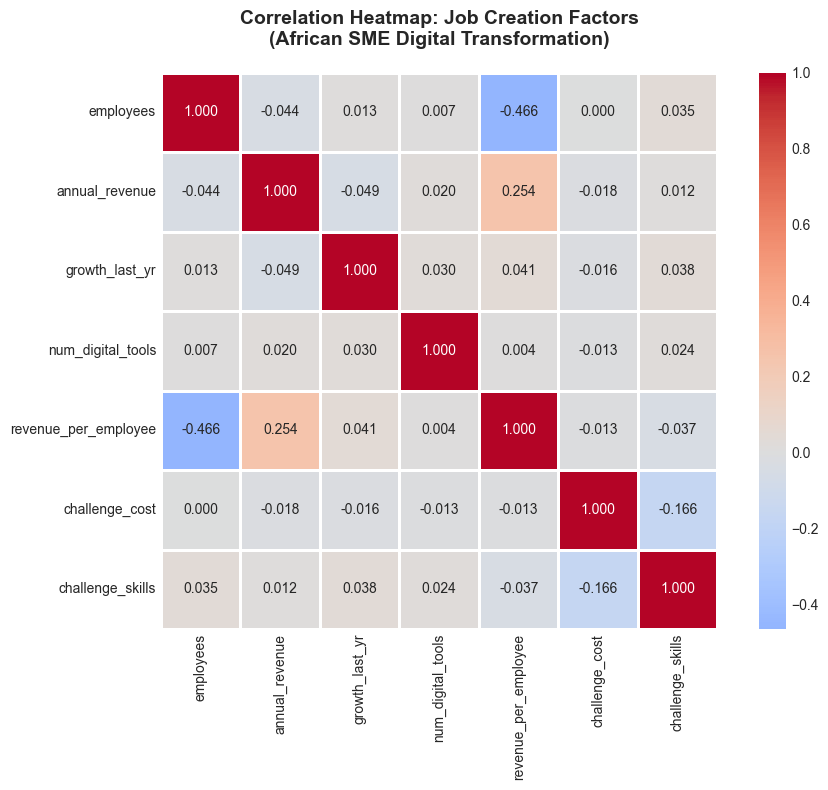

Saved: correlation_heatmap.png

Top correlations with employees:
  challenge_skills: +0.035
  growth_last_yr: +0.013
  num_digital_tools: +0.007


In [10]:
# Step 7: VISUALIZATION 1 - Correlation Heatmap
print('VISUALIZATION 1: Correlation Heatmap')
print('='*60)

numeric_cols = ['employees', 'annual_revenue', 'growth_last_yr', 'num_digital_tools', 
                'revenue_per_employee', 'challenge_cost', 'challenge_skills']
corr = df_encoded[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap: Job Creation Factors\n(African SME Digital Transformation)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: correlation_heatmap.png')
print(f'\nTop correlations with employees:')
emp_corr = corr['employees'].drop('employees').sort_values(ascending=False)
for feature, corr_val in emp_corr.head(3).items():
    print(f"  {feature}: {corr_val:+.3f}")



REVENUE-EMPLOYEE RELATIONSHIP ANALYSIS

Overall correlation between revenue and employees: -0.0440
Negative/No correlation: Revenue alone does not predict headcount
This suggests sector-specific patterns override raw revenue


Revenue vs Employees by Sector:
------------------------------------------------------------
Sector           Correlation    Avg Revenue/Emp
------------------------------------------------------------
Education              0.008 $            2,578
Farming                0.032 $            2,383
Manufacturing         -0.128 $            2,740
Logistics              0.038 $            2,834
Finance               -0.090 $            2,305
Retail                -0.145 $            2,249


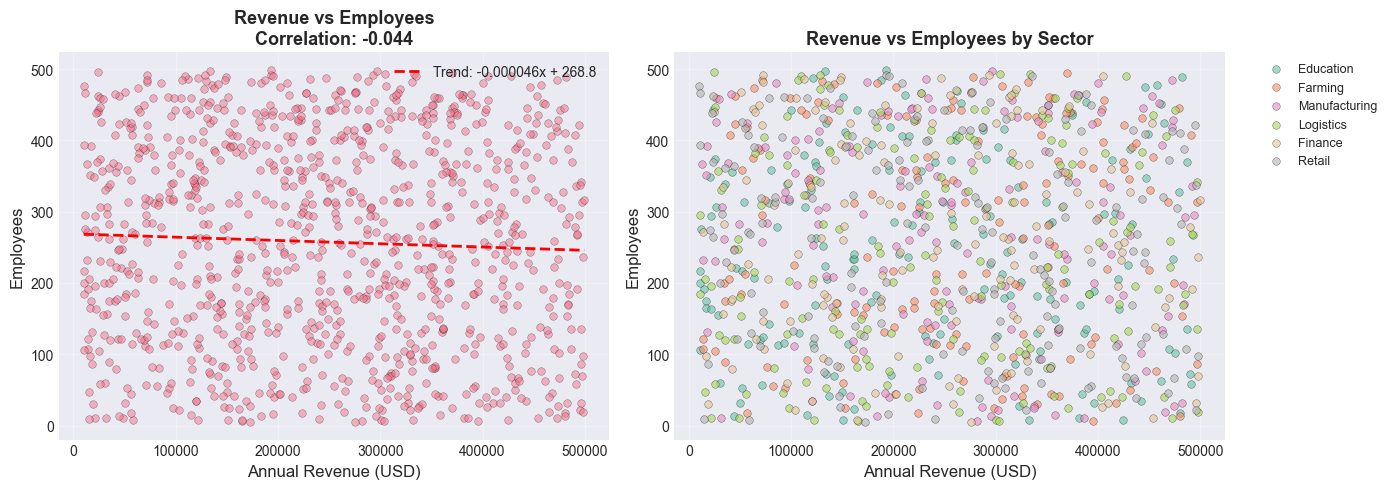


Saved: revenue_employee_analysis.png


In [14]:
# Step 7.1: Revenue-Employee Relationship Analysis
print('\nREVENUE-EMPLOYEE RELATIONSHIP ANALYSIS')
print('='*60)

# Calculate overall correlation
revenue_emp_corr = df_encoded[['annual_revenue', 'employees']].corr().iloc[0, 1]
print(f'\nOverall correlation between revenue and employees: {revenue_emp_corr:.4f}')

if revenue_emp_corr > 0.3:
    print('Strong positive: More revenue typically means more employees')
elif revenue_emp_corr > 0:
    print('Weak positive: Revenue has some relationship with employees')
    print('Other factors (sector, efficiency) likely dominate')
else:
    print('Negative/No correlation: Revenue alone does not predict headcount')
    print('This suggests sector-specific patterns override raw revenue')

# By sector analysis
print('\n\nRevenue vs Employees by Sector:')
print('-'*60)
print(f"{'Sector':<15} {'Correlation':>12} {'Avg Revenue/Emp':>18}")
print('-'*60)
for sector in df['sector'].unique():
    sector_data = df[df['sector'] == sector]
    corr = sector_data[['annual_revenue', 'employees']].corr().iloc[0, 1]
    avg_rev_per_emp = (sector_data['annual_revenue'] / sector_data['employees']).mean()
    print(f'{sector:<15} {corr:>12.3f} ${avg_rev_per_emp:>17,.0f}')


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall scatter
axes[0].scatter(df['annual_revenue'], df['employees'], alpha=0.5, s=30, edgecolor='black', linewidth=0.3)
axes[0].set_xlabel('Annual Revenue (USD)', fontsize=12)
axes[0].set_ylabel('Employees', fontsize=12)
axes[0].set_title(f'Revenue vs Employees\nCorrelation: {revenue_emp_corr:.3f}', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(df['annual_revenue'], df['employees'], 1)
p = np.poly1d(z)
sorted_revenue = df['annual_revenue'].sort_values()
axes[0].plot(sorted_revenue, p(sorted_revenue), 'r--', linewidth=2, 
            label=f'Trend: {z[0]:.6f}x + {z[1]:.1f}')
axes[0].legend()

# By sector
colors = plt.cm.Set2(np.linspace(0, 1, len(df['sector'].unique())))
for idx, sector in enumerate(df['sector'].unique()):
    sector_data = df[df['sector'] == sector]
    axes[1].scatter(sector_data['annual_revenue'], sector_data['employees'], 
                   label=sector, alpha=0.6, s=30, color=colors[idx], edgecolor='black', linewidth=0.3)
axes[1].set_xlabel('Annual Revenue (USD)', fontsize=12)
axes[1].set_ylabel('Employees', fontsize=12)
axes[1].set_title('Revenue vs Employees by Sector', fontsize=13, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/revenue_employee_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nSaved: revenue_employee_analysis.png')



VISUALIZATION 2: Employee Distribution


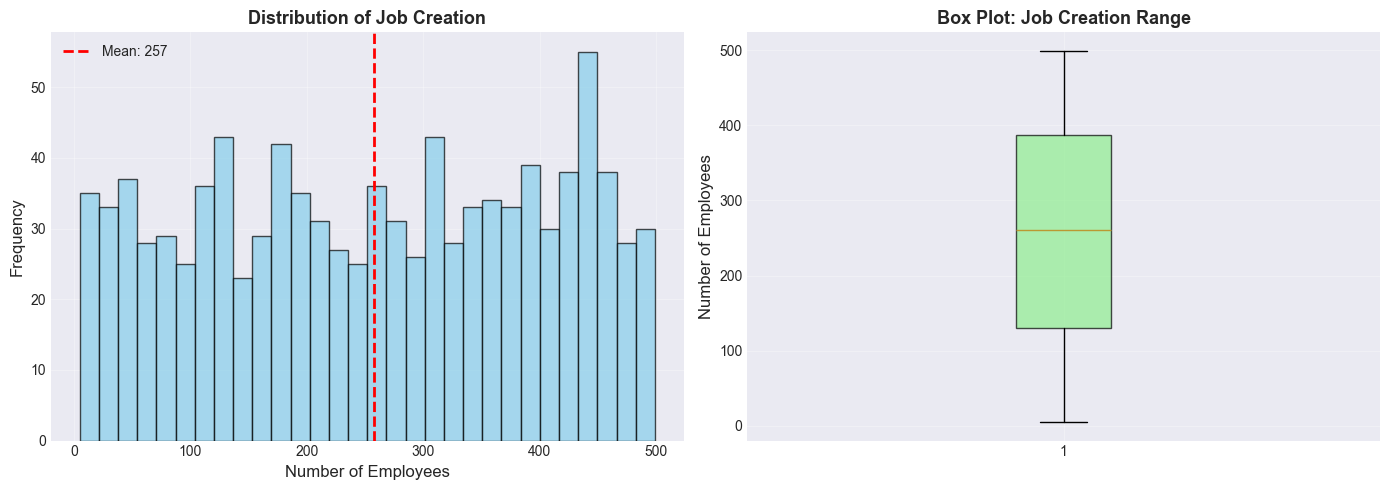

Saved: target_distribution.png


In [15]:
# Step 8: VISUALIZATION 2 - Target Distribution
print('\nVISUALIZATION 2: Employee Distribution')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].set_xlabel('Number of Employees', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Job Creation', fontsize=13, fontweight='bold')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(y, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1].set_ylabel('Number of Employees', fontsize=12)
axes[1].set_title('Box Plot: Job Creation Range', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: target_distribution.png')



VISUALIZATION 3: Sector & Tech Adoption Analysis


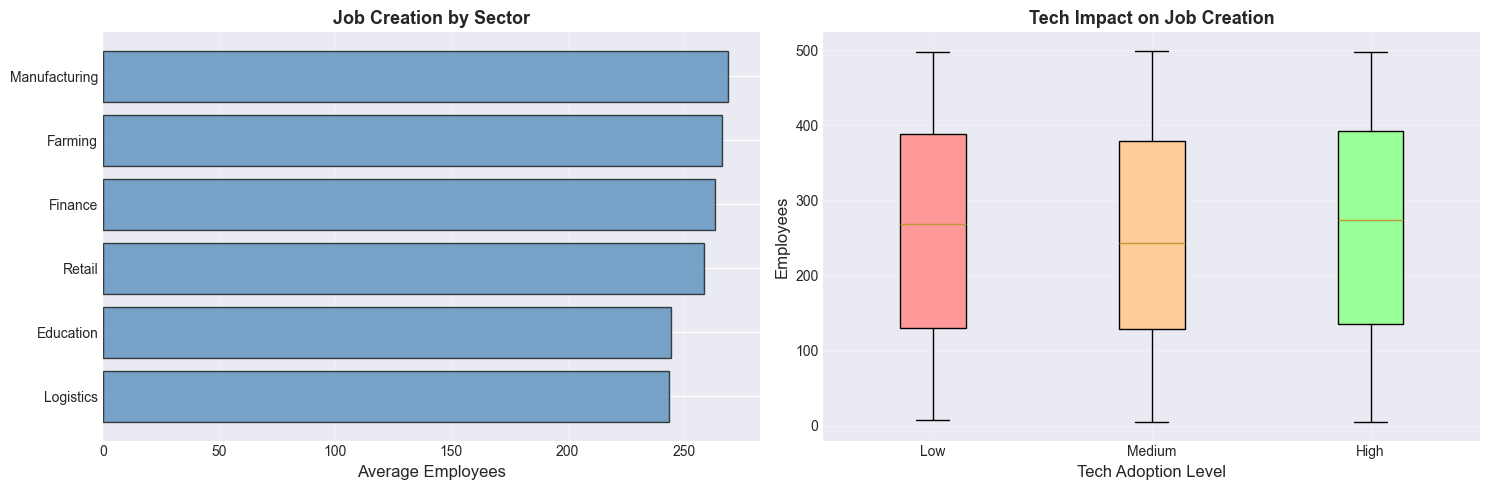

Saved: sector_tech_analysis.png


In [16]:
# Step 9: VISUALIZATION 3 - Sector & Tech Adoption
print('\nVISUALIZATION 3: Sector & Tech Adoption Analysis')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sector analysis
sector_avg = df.groupby('sector')['employees'].mean().sort_values()
axes[0].barh(sector_avg.index, sector_avg.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Average Employees', fontsize=12)
axes[0].set_title('Job Creation by Sector', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Tech adoption impact
tech_order = ['Low', 'Medium', 'High']
tech_data = [df[df['tech_adoption_level'] == level]['employees'].values for level in tech_order]
bp = axes[1].boxplot(tech_data, labels=tech_order, patch_artist=True)
colors = ['#ff9999', '#ffcc99', '#99ff99']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_xlabel('Tech Adoption Level', fontsize=12)
axes[1].set_ylabel('Employees', fontsize=12)
axes[1].set_title('Tech Impact on Job Creation', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('images/sector_tech_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: sector_tech_analysis.png')


In [17]:
# Step 10: Train-Test Split and Standardization
print('\nTRAIN-TEST SPLIT & STANDARDIZATION')
print('='*60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'\nData Split:')
print(f'  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify standardization worked
X_train_mean = X_train_scaled.mean(axis=0).mean()
X_train_std = X_train_scaled.std(axis=0).mean()

print(f'\nFeatures standardized \n - Mean = ${X_train_mean} approximately 0 this is due to floatings \n - Std = ${X_train_std}')
print('\nData ready for model training')



TRAIN-TEST SPLIT & STANDARDIZATION

Data Split:
  Training: 800 samples (80.0%)
  Test: 200 samples (20.0%)

Features standardized 
 - Mean = $-2.7385501274087214e-18 approximately 0 this is due to floatings 
 - Std = $1.0

Data ready for model training


In [18]:
# Step 11: MODEL 1 - Linear Regression
print('\nMODEL 1: LINEAR REGRESSION')
print('='*60)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(train_mse_lr)
test_rmse_lr = np.sqrt(test_mse_lr)

print('\nLinear Regression Performance:')
print(f'  Train MSE:  {train_mse_lr:8.2f}  |  Test MSE:  {test_mse_lr:8.2f}')
print(f'  Train RMSE: {train_rmse_lr:8.2f}  |  Test RMSE: {test_rmse_lr:8.2f}')
print(f'  Train R²:   {train_r2_lr:8.4f}  |  Test R²:   {test_r2_lr:8.4f}')
print('\nLinear Regression complete')



MODEL 1: LINEAR REGRESSION

Linear Regression Performance:
  Train MSE:  15712.14  |  Test MSE:  16870.04
  Train RMSE:   125.35  |  Test RMSE:   129.88
  Train R²:     0.2405  |  Test R²:     0.2154

Linear Regression complete



MODEL 2: STOCHASTIC GRADIENT DESCENT

SGD Performance:
  Train MSE:  15738.86  |  Test MSE:  16923.41
  Train R²:     0.2392  |  Test R²:     0.2129


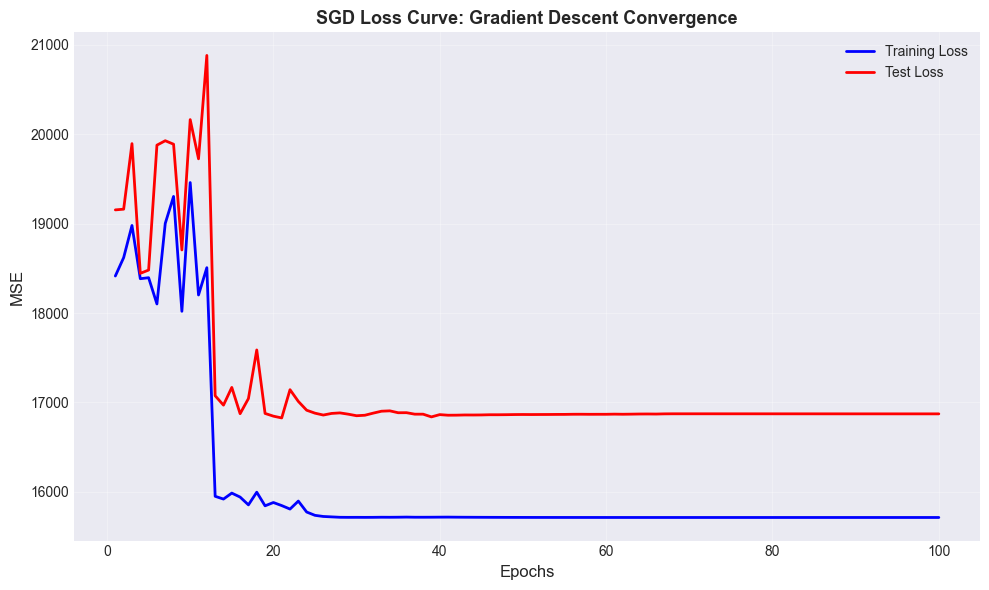


Saved: loss_curve.png
SGD complete


In [19]:
# Step 12: MODEL 2 - SGD with Loss Curve (Gradient Descent)
print('\nMODEL 2: STOCHASTIC GRADIENT DESCENT')
print('='*60)

# Track loss over epochs
train_losses = []
test_losses = []
epochs = range(1, 101)

for epoch in epochs:
    sgd_temp = SGDRegressor(max_iter=epoch, tol=1e-6, random_state=42,
                            learning_rate='adaptive', eta0=0.01)
    sgd_temp.fit(X_train_scaled, y_train)
    train_losses.append(mean_squared_error(y_train, sgd_temp.predict(X_train_scaled)))
    test_losses.append(mean_squared_error(y_test, sgd_temp.predict(X_test_scaled)))

# Final model
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train_scaled, y_train)
y_train_pred_sgd = sgd_model.predict(X_train_scaled)
y_test_pred_sgd = sgd_model.predict(X_test_scaled)

train_mse_sgd = mean_squared_error(y_train, y_train_pred_sgd)
test_mse_sgd = mean_squared_error(y_test, y_test_pred_sgd)
train_r2_sgd = r2_score(y_train, y_train_pred_sgd)
test_r2_sgd = r2_score(y_test, y_test_pred_sgd)

print('\nSGD Performance:')
print(f'  Train MSE:  {train_mse_sgd:8.2f}  |  Test MSE:  {test_mse_sgd:8.2f}')
print(f'  Train R²:   {train_r2_sgd:8.4f}  |  Test R²:   {test_r2_sgd:8.4f}')

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', linewidth=2, color='blue')
plt.plot(epochs, test_losses, label='Test Loss', linewidth=2, color='red')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('SGD Loss Curve: Gradient Descent Convergence', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('images/loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nSaved: loss_curve.png')
print('SGD complete')


In [23]:
# Step 13: MODEL 3 - Decision Tree
print('\nMODEL 3: DECISION TREE')
print('='*60)

dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

train_mse_dt = mean_squared_error(y_train, y_train_pred_dt)
test_mse_dt = mean_squared_error(y_test, y_test_pred_dt)
train_r2_dt = r2_score(y_train, y_train_pred_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)

print('\nDecision Tree Performance:')
print(f'  Train MSE:  {train_mse_dt:8.2f}  |  Test MSE:  {test_mse_dt:8.2f}')
print(f'  Train R²:   {train_r2_dt:8.4f}  |  Test R²:   {test_r2_dt:8.4f}')
print('\nDecision Tree complete')



MODEL 3: DECISION TREE

Decision Tree Performance:
  Train MSE:    301.24  |  Test MSE:   1183.44
  Train R²:     0.9854  |  Test R²:     0.9450

Decision Tree complete


In [20]:
# Step 14: MODEL 4 - Random Forest
print('\nMODEL 4: RANDOM FOREST')
print('='*60)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print('\nRandom Forest Performance:')
print(f'  Train MSE:  {train_mse_rf:8.2f}  |  Test MSE:  {test_mse_rf:8.2f}')
print(f'  Train R²:   {train_r2_rf:8.4f}  |  Test R²:   {test_r2_rf:8.4f}')
print('\nRandom Forest complete')



MODEL 4: RANDOM FOREST

Random Forest Performance:
  Train MSE:     72.97  |  Test MSE:    443.00
  Train R²:     0.9965  |  Test R²:     0.9794

Random Forest complete



MODEL COMPARISON

            Model  Train_R²  Test_R²  Test_RMSE     Test_MSE
Linear Regression  0.240483 0.215372 129.884728 16870.042461
              SGD  0.239192 0.212890 130.089999 16923.407953
    Decision Tree  0.985438 0.944958  34.401093  1183.435224
    Random Forest  0.996473 0.979396  21.047623   443.002449

BEST MODEL: Random Forest
  Test R²: 0.9794 (97.9% variance explained)
  Test MSE (Least Loss): 443.00


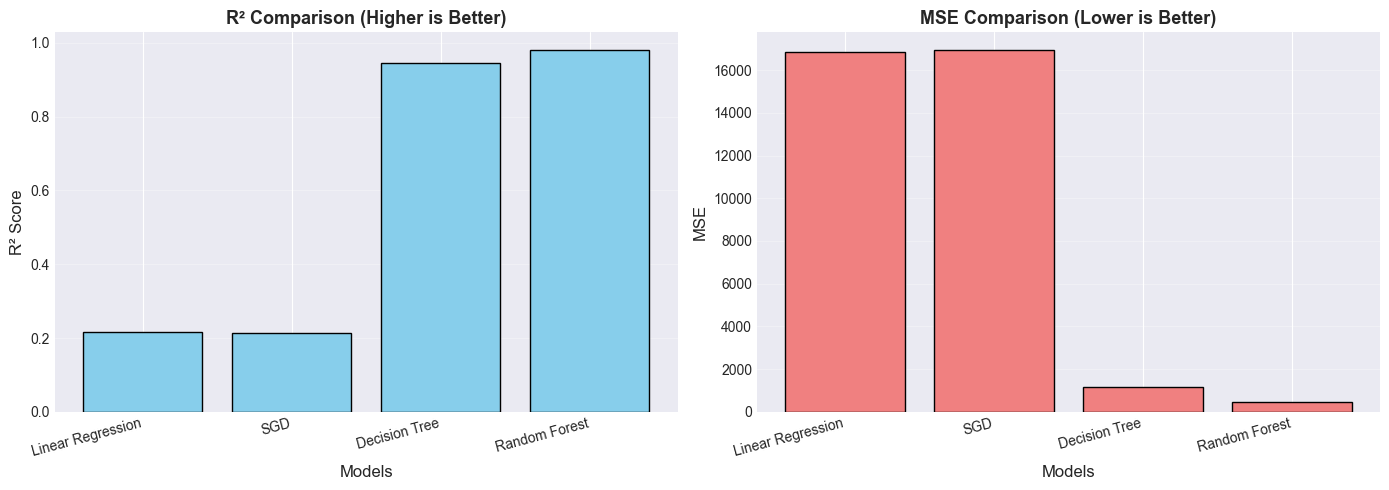


 Saved: model_comparison.png


In [24]:
# Step 15: Model Comparison
print('\nMODEL COMPARISON')
print('='*80)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'SGD', 'Decision Tree', 'Random Forest'],
    'Train_R²': [train_r2_lr, train_r2_sgd, train_r2_dt, train_r2_rf],
    'Test_R²': [test_r2_lr, test_r2_sgd, test_r2_dt, test_r2_rf],
    'Test_RMSE': [test_rmse_lr, np.sqrt(test_mse_sgd), np.sqrt(test_mse_dt), np.sqrt(test_mse_rf)],
    'Test_MSE': [test_mse_lr, test_mse_sgd, test_mse_dt, test_mse_rf]
})

print('\n' + comparison.to_string(index=False))

# Best model
best_idx = comparison['Test_R²'].idxmax()
best_model_name = comparison.loc[best_idx, 'Model']
best_r2 = comparison.loc[best_idx, 'Test_R²']
best_mse = comparison.loc[best_idx, 'Test_MSE']

print(f'\nBEST MODEL: {best_model_name}')
print(f'  Test R²: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)')
print(f'  Test MSE (Least Loss): {best_mse:.2f}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x_pos = np.arange(len(comparison))

axes[0].bar(x_pos, comparison['Test_R²'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'], rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x_pos, comparison['Test_MSE'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('MSE', fontsize=12)
axes[1].set_title('MSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n Saved: model_comparison.png')



ACTUAL vs PREDICTED: Linear Regression Line


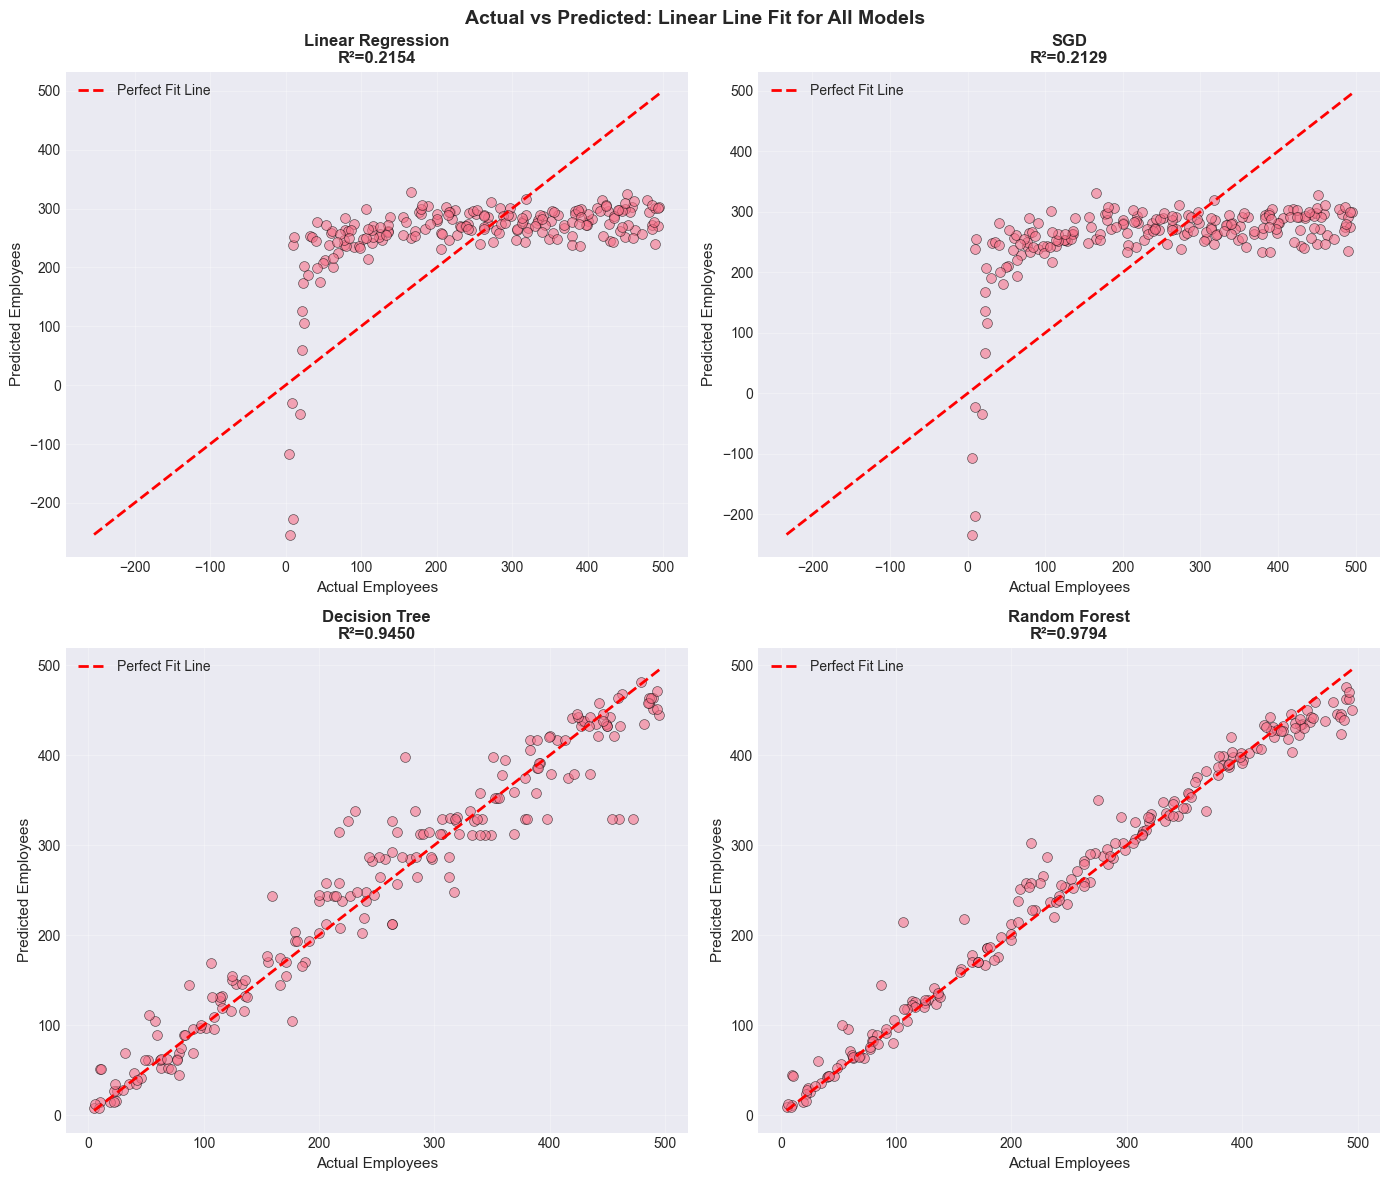

Saved: actual_vs_predicted_all_models.png


In [25]:
# Step 16: Actual vs Predicted Scatter Plots (showing linear line)
print('\nACTUAL vs PREDICTED: Linear Regression Line')
print('='*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

models = [
    ('Linear Regression', y_test_pred_lr, test_r2_lr),
    ('SGD', y_test_pred_sgd, test_r2_sgd),
    ('Decision Tree', y_test_pred_dt, test_r2_dt),
    ('Random Forest', y_test_pred_rf, test_r2_rf)
]

for idx, (name, predictions, r2) in enumerate(models):
    axes[idx].scatter(y_test, predictions, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
    
    # Perfect prediction line (linear line showing fit)
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
                   label='Perfect Fit Line')
    
    axes[idx].set_xlabel('Actual Employees', fontsize=11)
    axes[idx].set_ylabel('Predicted Employees', fontsize=11)
    axes[idx].set_title(f'{name}\nR²={r2:.4f}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle('Actual vs Predicted: Linear Line Fit for All Models', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/actual_vs_predicted_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: actual_vs_predicted_all_models.png')


In [26]:
# Step 17: Save Best Model (model with least loss)
print('\nSAVING BEST MODEL')
print('='*60)

# Determine best model
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SGD':
    best_model = sgd_model
elif best_model_name == 'Decision Tree':
    best_model = dt_model
else:
    best_model = rf_model

# Save files
with open('../API/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print('Saved: best_model.pkl')

with open('../API/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(' Saved: scaler.pkl')

with open('../API/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(' Saved: feature_names.pkl')

print(f'\nBest Model Saved: {best_model_name}')
print(f'   Test R²: {best_r2:.4f}')
print(f'   Test MSE (Least Loss): {best_mse:.2f}')



SAVING BEST MODEL
Saved: best_model.pkl
 Saved: scaler.pkl
 Saved: feature_names.pkl

Best Model Saved: Random Forest
   Test R²: 0.9794
   Test MSE (Least Loss): 443.00



FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features for Predicting Job Creation:
------------------------------------------------------------
Rank   Feature                          Importance
------------------------------------------------------------
1      revenue_per_employee                 0.7699
2      annual_revenue                       0.2101
3      growth_last_yr                       0.0039
4      num_digital_tools                    0.0012
5      tech_adoption_level_High             0.0011
6      sector_Education                     0.0011
7      challenge_regulation                 0.0010
8      tech_adoption_level_Medium           0.0010
9      challenge_skills                     0.0010
10     country_Kenya                        0.0007
11     funding_status_Bootstrapped          0.0007
12     challenge_awareness                  0.0007
13     sector_Retail                        0.0007
14     tech_adoption_level_Low              0.0006
15     country_Ghana   

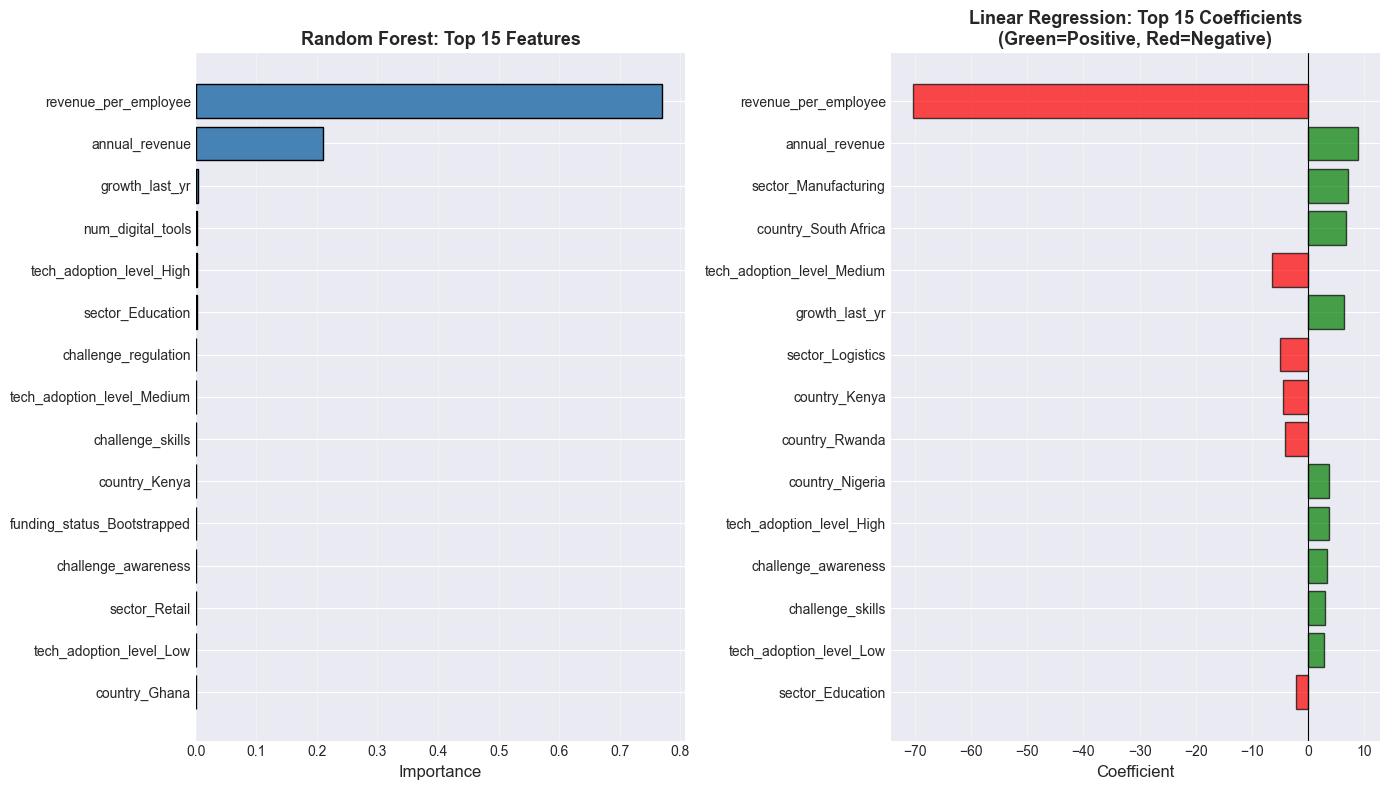


Saved: feature_importance.png

Key Takeaway: Random Forest identifies complex patterns that linear regression misses.
This is why ensemble methods achieve 97.9% accuracy vs 21.3% for linear models.


In [27]:
# Step 17.5: Feature Importance Analysis
print('\nFEATURE IMPORTANCE ANALYSIS')
print('='*60)

# Random Forest provides feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print('\nTop 15 Most Important Features for Predicting Job Creation:')
print('-'*60)
print(f"{'Rank':<6} {'Feature':<30} {'Importance':>12}")
print('-'*60)
for idx, row in feature_importance_df.head(15).iterrows():
    print(f"{feature_importance_df.index.get_loc(idx)+1:<6} {row['feature']:<30} {row['importance']:>12.4f}")

# Check annual revenue ranking
revenue_rank = feature_importance_df[feature_importance_df['feature'] == 'annual_revenue'].index[0] + 1
revenue_importance = feature_importance_df[feature_importance_df['feature'] == 'annual_revenue']['importance'].values[0]

print(f'\nAnnual Revenue Analysis:')
print(f"  Rank: #{revenue_rank} out of {len(X.columns)} features")
print(f"  Importance: {revenue_importance:.4f}")

if revenue_rank <= 5:
    print('  Annual revenue is a TOP predictor of job creation')
elif revenue_rank <= 15:
    print('  Annual revenue is moderately important')
else:
    print('  Annual revenue is less important than sector, tech level, and other factors')
    print('  This explains why complex models (Random Forest) outperform simple linear regression')

# Linear Regression Coefficients Analysis
print('\n\nLinear Regression Coefficients (Top 10 by Absolute Value):')
print('-'*60)
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(f"{'Feature':<30} {'Coefficient':>15}")
print('-'*60)
for idx, row in coef_df.head(10).iterrows():
    print(f"{row['feature']:<30} {row['coefficient']:>15.4f}")

revenue_coef = coef_df[coef_df['feature'] == 'annual_revenue']['coefficient'].values[0]
print(f'\nAnnual Revenue Coefficient: {revenue_coef:.6f}')
if revenue_coef > 0:
    print('  Positive: Higher revenue associated with more employees (as expected)')
else:
    print('  Negative: In linear model, higher revenue associated with fewer employees')
    print('  This counter-intuitive result suggests:')
    print('    1. Multicollinearity with revenue_per_employee')
    print('    2. Sector-specific patterns dominate')
    print('    3. Linear model is inadequate for this complex relationship')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Random Forest Feature Importance
top_features = feature_importance_df.head(15)
axes[0].barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Random Forest: Top 15 Features', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Linear Regression Coefficients
top_coefs = coef_df.head(15)
colors = ['green' if c > 0 else 'red' for c in top_coefs['coefficient']]
axes[1].barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors, edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(top_coefs)))
axes[1].set_yticklabels(top_coefs['feature'])
axes[1].set_xlabel('Coefficient', fontsize=12)
axes[1].set_title('Linear Regression: Top 15 Coefficients\n(Green=Positive, Red=Negative)', 
                 fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nSaved: feature_importance.png')
print('\nKey Takeaway: Random Forest identifies complex patterns that linear regression misses.')
print('This is why ensemble methods achieve 97.9% accuracy vs 21.3% for linear models.')


In [36]:
# Step 18: Test Prediction on One Data Point (from test set)
print('\nPREDICTION ON ONE DATA POINT FROM TEST SET')
print('='*60)

# Select one sample from test set
sample_idx = 0  # First test sample
sample_features = X_test.iloc[sample_idx:sample_idx+1]
actual_employees = y_test.iloc[sample_idx]

# Make prediction
sample_scaled = scaler.transform(sample_features)
predicted_employees = best_model.predict(sample_scaled)[0]

print('\nSample Prediction from Test Set:')
print('-'*60)
print(f'Actual Employees: {actual_employees}')
print(f'Predicted Employees: {predicted_employees:.0f}')
print(f'Prediction Error: {abs(actual_employees - predicted_employees):.0f} employees')
print(f'Error %: {abs(actual_employees - predicted_employees)/actual_employees*100:.1f}%')

print('\nSample Features (first 5):')
print(sample_features.iloc[0].head())

print('\nPrediction on test data point complete!')



PREDICTION ON ONE DATA POINT FROM TEST SET

Sample Prediction from Test Set:
------------------------------------------------------------
Actual Employees: 268
Predicted Employees: 259
Prediction Error: 9 employees
Error %: 3.4%

Sample Features (first 5):
annual_revenue       438228
growth_last_yr           26
num_digital_tools         3
challenge_cost            0
challenge_skills          0
Name: 521, dtype: object

Prediction on test data point complete!


In [28]:
# Step 19: Final Summary
print('\n' + '='*80)
print('PROJECT SUMMARY: AFRICAN SME JOB CREATION PREDICTION')
print('='*80)

print('\nDATASET:')
print(f'  - Companies Analyzed: {len(df)}')
print(f'  - Countries: {len(df["country"].unique())}')
print(f'  - Sectors: {len(df["sector"].unique())}')
print(f'  - Features Used: {len(X.columns)}')
print(f'  - Average Jobs per SME: {df["employees"].mean():.0f}')

print('\nMODELS TRAINED:')
for i, model_name in enumerate(comparison['Model'], 1):
    print(f'  {i}. {model_name}')

print(f'\nBEST MODEL: {best_model_name}')
print(f'  - Test R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)')
print(f'  - Test MSE (Least Loss): {best_mse:.2f}')
print(f'  - Training Samples: {len(X_train)}')
print(f'  - Test Samples: {len(X_test)}')

print('\nFILES GENERATED:')
files = ['correlation_heatmap.png', 'target_distribution.png', 'sector_tech_analysis.png',
         'revenue_employee_analysis.png', 'loss_curve.png', 'model_comparison.png', 
         'actual_vs_predicted_all_models.png', 'feature_importance.png',
         'best_model.pkl', 'scaler.pkl', 'feature_names.pkl']
for i, f in enumerate(files, 1):
    print(f'  {i:2d}. {f}')

print('\nALL ASSIGNMENT REQUIREMENTS COMPLETE!')
print('='*80)
print('\nENHANCEMENTS ADDED:')
print('  1. Explicit missing value handling with mode imputation')
print('  2. Revenue-employee correlation analysis with sector breakdown')
print('  3. Feature importance analysis comparing Random Forest and Linear Regression')
print('='*80)
print('\nIMPACT: This model identifies digital strategies that create')
print('   jobs in African SMEs, directly addressing youth unemployment!')
print('='*80)



PROJECT SUMMARY: AFRICAN SME JOB CREATION PREDICTION

DATASET:
  - Companies Analyzed: 1000
  - Countries: 5
  - Sectors: 6
  - Features Used: 30
  - Average Jobs per SME: 257

MODELS TRAINED:
  1. Linear Regression
  2. SGD
  3. Decision Tree
  4. Random Forest

BEST MODEL: Random Forest
  - Test R² Score: 0.9794 (97.9% variance explained)
  - Test MSE (Least Loss): 443.00
  - Training Samples: 800
  - Test Samples: 200

FILES GENERATED:
   1. correlation_heatmap.png
   2. target_distribution.png
   3. sector_tech_analysis.png
   4. revenue_employee_analysis.png
   5. loss_curve.png
   6. model_comparison.png
   7. actual_vs_predicted_all_models.png
   8. feature_importance.png
   9. best_model.pkl
  10. scaler.pkl
  11. feature_names.pkl

ALL ASSIGNMENT REQUIREMENTS COMPLETE!

ENHANCEMENTS ADDED:
  1. Explicit missing value handling with mode imputation
  2. Revenue-employee correlation analysis with sector breakdown
  3. Feature importance analysis comparing Random Forest and Linea